<h1 style="text-align:center;font-size:30px;" > Disaster Tweets </h1>

<h1> Description </h1>

<p>twitter is a place where users post and interact with messages known as "tweets". tweets are limited to 280 characters. this tweets could be image/words.
</p>

__ Problem Statement __
- Twitter has become an important communication channel in times of emergency.it’s not always clear whether a person’s words are actually announcing a disaster.
- Now we are tasked with predict whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

<h1> Data Overview </h1>
<p> 
- Data will be in a file Train.csv & test .csv <br>
- Train.csv contains 5 columns : id, text, location, keyword, target <br>
- Number of rows in Train.csv = 7613
<p>

Files

    train.csv - the training set
    test.csv - the test set
    sample_submission.csv - a sample submission file

Columns

    id - a unique identifier for each tweet
    text - the text of the tweet
    location - the location the tweet was sent from (may be blank)
    keyword - a particular keyword from the tweet (may be blank)
    target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

<h2> Type of Machine Leaning Problem </h2>

<p> It is a binary classification problem, for a given datapoints or tweets we need to predict if the tweet is about real disaster or not. </p>

# 1. Reading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
#text preprocess
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re

from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
from scipy import sparse
import lightgbm as lgb
from sklearn.metrics import roc_curve, auc, confusion_matrix, log_loss, f1_score

In [2]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print("Number of data points in train data", train.shape)
print('-'*50)
print("The attributes of data :", train.columns.values)

Number of data points in train data (7613, 5)
--------------------------------------------------
The attributes of data : ['id' 'keyword' 'location' 'text' 'target']


# 2 Exploratory Data Analysis
<h3>  2.1 Distribution of data points among output classes</h3>

Number of tweets that are real disaster  3271 , ( 42.96597924602653 %)
Number of tweets that are not disaster  4342 , ( 57.03402075397347 %)


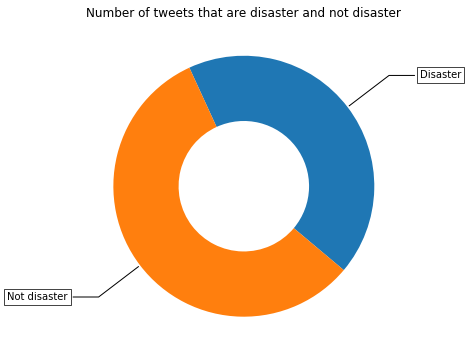

In [4]:
y_value_counts = train['target'].value_counts()
print("Number of tweets that are real disaster ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of tweets that are not disaster ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Disaster", "Not disaster"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Number of tweets that are disaster and not disaster")

plt.show()

### Checking for null values

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


**Note:**
- From above information we found that there are null values in keywords and location

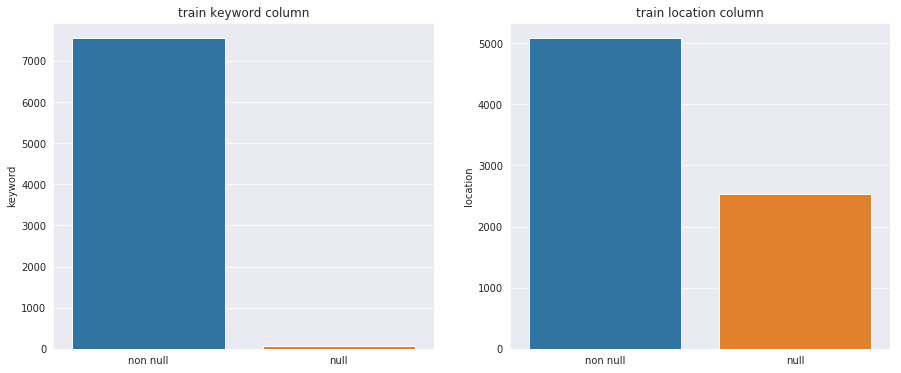

train column Keyword percentage of null value is 0.81
train column location percentage of null value is 49.86


In [6]:
plt.figure(figsize=(15,6))
sns.set_style('darkgrid')
plt.subplot(1, 2, 1)
plt.title('train keyword column') 
x=train['keyword'].isnull().value_counts()
sns.barplot(['non null','null'],x)

sns.set_style('darkgrid')
plt.subplot(1, 2, 2)
plt.title('train location column') 
x=train['location'].isnull().value_counts()
sns.barplot(['non null','null'],x)
plt.show()

print("train column Keyword percentage of null value is %.2f" %(train.keyword.isnull().sum()/train.keyword.notnull().sum()*100))
print("train column location percentage of null value is %.2f" %(train.location.isnull().sum()/train.location.notnull().sum()*100))

**Note:**
- for location column we are having almost 50% of null values and there are 3341 unique words. 
- its better to discard location feature than to impute it. As imputing almost 40% of your data would be introducing significant amount of error in it.
- we will be keeping the keyword column because it will not have any impact over data imbalance. since the percentage of null value in keyword column is very low 0.8% which is 61 out of 7613 data points.

Keyword replace NaN with string

In [7]:
train['keyword'].fillna("No keyword",inplace=True)
test['keyword'].fillna("No keyword",inplace=True)

#### Drop location feature

In [8]:
train.drop(['location'],axis=1,inplace=True)
test.drop(['location'],axis=1,inplace=True)

In [9]:
train.shape

(7613, 4)

### 2.2 Univariate Analysis:

### Text feature

In [10]:
word_count = train.text.str.split().apply(len).value_counts()
print('total number of words present in each text feature')
print(word_count)

total number of words present in each text feature
11    497
18    494
17    494
16    451
14    450
13    445
15    425
12    415
20    409
19    390
9     363
10    334
21    296
8     293
22    279
7     242
23    220
24    189
6     186
5     159
25    129
4     115
26     98
3      75
27     60
28     41
2      34
29     13
1       8
30      6
31      3
Name: text, dtype: int64


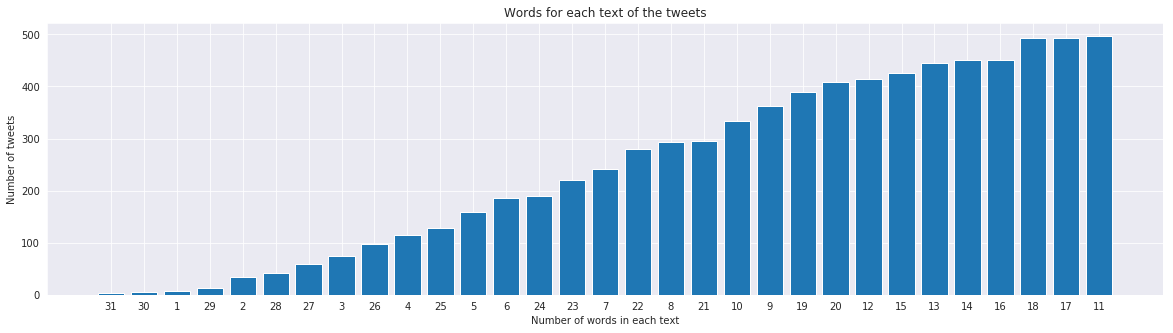

In [11]:
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of tweets')
plt.xlabel('Number of words in each text')
plt.title('Words for each text of the tweets')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

**Note:**
- from above chart there are almost 500 tweets have words count of 11 to 20
- Very few tweets have words >30

In [12]:
disaster_word_count = train[train['target']==1]['text'].str.split().apply(len)
disaster_word_count = disaster_word_count.values

not_disater_word_count = train[train['target']==0]['text'].str.split().apply(len)
not_disater_word_count = not_disater_word_count.values

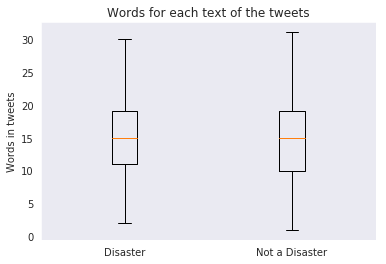

In [13]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([disaster_word_count, not_disater_word_count])
plt.title('Words for each text of the tweets')
plt.xticks([1,2],('Disaster','Not a Disaster'))
plt.ylabel('Words in tweets')
plt.grid()
plt.show()

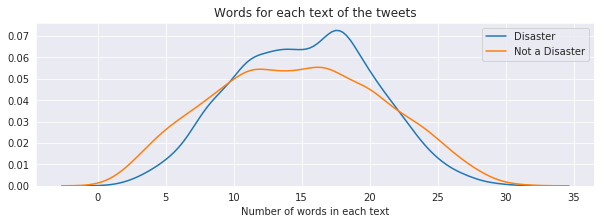

In [14]:
plt.figure(figsize=(10,3))
sns.distplot(disaster_word_count, hist=False, label="Disaster")
sns.distplot(not_disater_word_count, hist=False, label="Not a Disaster")
plt.title('Words for each text of the tweets')
plt.xlabel('Number of words in each text')
plt.legend()
plt.show()

**Note:**
- we clearly identified that number words frequency in tweets says its is disaster or not are almost equal. 
- word counts are equally balanced in both class we can find it from box plot and distribution plot.

### keyword feature

In [15]:
word_count_k = train.keyword.value_counts()
print('total number of words present in each keyword')
print(word_count_k)

total number of words present in each keyword
No keyword               61
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64


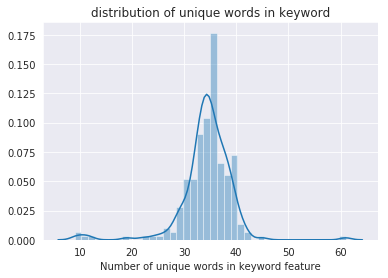

In [16]:
sns.distplot(word_count_k.values)
plt.title('distribution of unique words in keyword')
plt.xlabel('Number of unique words in keyword feature')
plt.show()

**Note:**
* total of 221 unique words present in the keyword feature.
* there are few words which occurs more often between 30 to 40 times
* all the words present in each keyword feature have only single word with %20 which is space.
* “%20,” it represents a space in an encoded URL
* we will be replacing the %20 with space in all keyword feature and do the data analysis.

In [17]:
train.keyword = train.keyword.str.replace('%20', ' ', regex=True)
test.keyword = test.keyword.str.replace('%20', ' ', regex=True)

total number of words present in each text feature
1    6387
2    1193
3      33
Name: keyword, dtype: int64


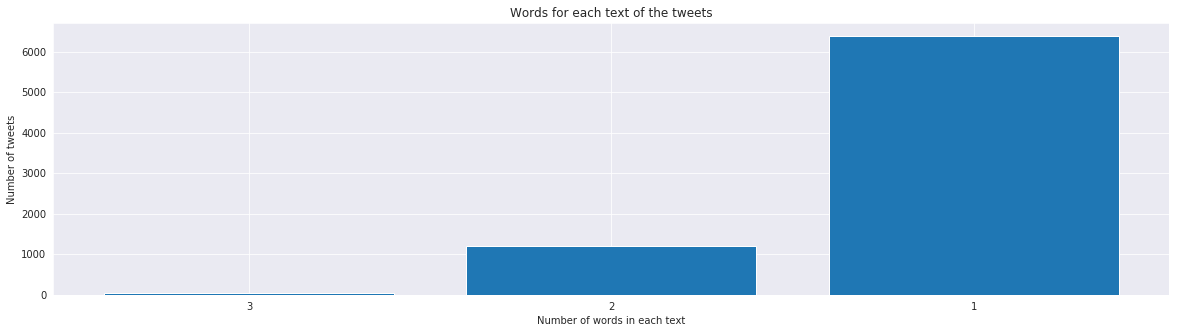

In [18]:
keyword_count = train.keyword.str.split().apply(len).value_counts()
print('total number of words present in each text feature')
print(keyword_count)
keyword_dict = dict(keyword_count)
keyword_dict = dict(sorted(keyword_dict.items(), key=lambda kv: kv[1]))


ind_key = np.arange(len(keyword_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind_key, list(keyword_dict.values()))

plt.ylabel('Number of tweets')
plt.xlabel('Number of words in each text')
plt.title('Words for each text of the tweets')
plt.xticks(ind_key, list(keyword_dict.keys()))
plt.show()

**Note:**
- maximum word count is 3. 
- there are 6387 single word, 1132 two words and 33 three words in keyword feature.

In [19]:
train.keyword[101:120]

101      accident
102    aftershock
103    aftershock
104    aftershock
105    aftershock
106    aftershock
107    aftershock
108    aftershock
109    aftershock
110    aftershock
111    aftershock
112    aftershock
113    aftershock
114    aftershock
115    aftershock
116    aftershock
117    aftershock
118    aftershock
119    aftershock
Name: keyword, dtype: object

In [20]:
train.text[101:120]

101    I still have not heard Church Leaders of Kenya...
102    @afterShock_DeLo scuf ps live and the game... cya
103    'The man who can drive himself further once th...
104    320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/yN...
105    'There is no victory at bargain basement price...
106    320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...
107    'Nobody remembers who came in second.' Charles...
108    @afterShock_DeLo im speaking from someone that...
109    'The harder the conflict the more glorious the...
110    #GrowingUpSpoiled going clay pigeon shooting a...
111    So i guess no one actually wants any free Afte...
112    Aftershock was the most terrifying best roller...
113                   Aftershock https://t.co/xMWODFMtUI
114    320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/M4...
115    320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...
116    320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/e1...
117    @KJForDays I'm seeing them and Issues at after...
118    320 [IR] ICEMOON [AFTERS

**Note:**
- Keyword feature is nothing but the keyword used in the text feature. so ther is correlation between this two features. 
- based on this we will be extracting couple of features which will be used in our model.

# 3 Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____n_special_word____ = number of special words count starts with @, # and digits from text feature
 - ____freq_keyword____ = Frequency of keyword 
 - ____textlen____ = Length of text
 - ____keywordlen____ = Length of keyword
 - ____text_n_words____ = Number of words in text
 - ____keyword_n_words____ = Number of words in keyword
 - ____word_Common____ = (Number of common unique words in keyword and text)
 - ____word_Total____ =(Total num of words in text + Total num of words in keyword)
 - ____word_share____ = (word_common)/(word_Total)


In [21]:
train['n_special_word'] = train['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#') or x.startswith('@') or x.isdigit()]))
test['n_special_word'] = test['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#') or x.startswith('@') or x.isdigit()]))

train['freq_keyword'] = train.groupby('keyword')['keyword'].transform('count')
test['freq_keyword'] = test.groupby('keyword')['keyword'].transform('count')

train['textlen'] = train['text'].str.len() 
train['keywordlen'] = train['keyword'].str.len()
train['text_n_words'] = train['text'].apply(lambda row: len(row.split(" ")))
train['keyword_n_words'] = train['keyword'].apply(lambda row: len(row.split(" ")))

test['textlen'] = test['text'].str.len() 
test['keywordlen'] = test['keyword'].str.len()
test['text_n_words'] = test['text'].apply(lambda row: len(row.split(" ")))
test['keyword_n_words'] = test['keyword'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['keyword'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text'].split(" ")))    
    return 1.0 * len(w1 & w2)
train['word_Common'] = train.apply(normalized_word_Common, axis=1)
test['word_Common'] = test.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['keyword'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
train['word_Total'] = train.apply(normalized_word_Total, axis=1)
test['word_Total'] = test.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['keyword'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
train['word_share'] = train.apply(normalized_word_share, axis=1)
test['word_share'] = test.apply(normalized_word_share, axis=1)

train.head(5)

,id,keyword,text,target,n_special_word,freq_keyword,textlen,keywordlen,text_n_words,keyword_n_words,word_Common,word_Total,word_share
0,1,No keyword,Our Deeds are the Reason of this #earthquake M...,1,1,61,69,10,13,2,0.0,15.0,0.000000
1,4,No keyword,Forest fire near La Ronge Sask. Canada,1,0,61,38,10,7,2,0.0,9.0,0.000000
2,5,No keyword,All residents asked to 'shelter in place' are ...,1,0,61,133,10,22,2,1.0,22.0,0.045455
3,6,No keyword,"13,000 people receive #wildfires evacuation or...",1,1,61,65,10,9,2,0.0,11.0,0.000000
4,7,No keyword,Just got sent this photo from Ruby #Alaska as ...,1,2,61,88,10,17,2,0.0,18.0,0.000000


# 4 Preprocessing of Text

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [22]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s\/]*))*", "", x)
    x = x.replace("  ", " ")
    x = x.replace("_", " ")
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x, "lxml")
        x = example1.get_text()
               
    
    return x

In [23]:
train["text"] = train["text"].apply(preprocess)
test["text"] = test["text"].apply(preprocess)
train["keyword"] = train["keyword"].apply(preprocess)
test["keyword"] = test["keyword"].apply(preprocess)

#### Checking for null or empty values again

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 13 columns):
id                 7613 non-null int64
keyword            7613 non-null object
text               7613 non-null object
target             7613 non-null int64
n_special_word     7613 non-null int64
freq_keyword       7613 non-null int64
textlen            7613 non-null int64
keywordlen         7613 non-null int64
text_n_words       7613 non-null int64
keyword_n_words    7613 non-null int64
word_Common        7613 non-null float64
word_Total         7613 non-null float64
word_share         7613 non-null float64
dtypes: float64(3), int64(8), object(2)
memory usage: 773.3+ KB


# 5. Visualization

<h3> 5.1 Plotting Word clouds </h3>

In [25]:
train_disaster = train[train['target'] == 1]
train_not_disaster = train[train['target'] == 0]
dis = ' '.join(train_disaster.text)
not_dis = ' '.join(train_not_disaster.text)
stopwordswc = set(STOPWORDS)

(-0.5, 399.5, 199.5, -0.5)

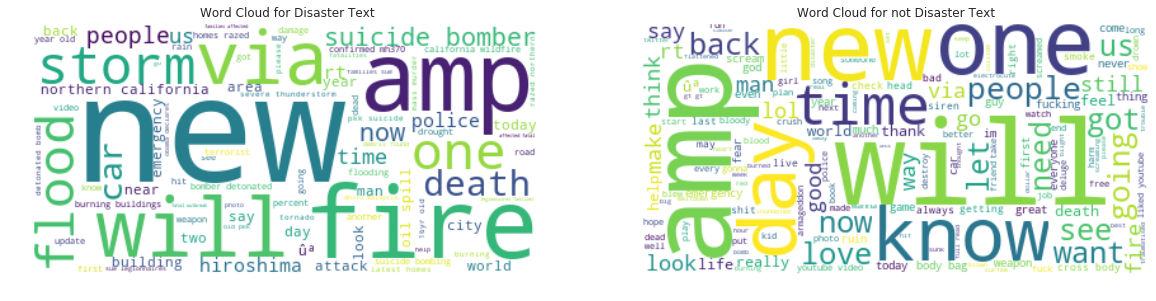

In [26]:

wc1 = WordCloud(background_color="white", max_words=len(dis), stopwords=stopwordswc)
wc1.generate(dis)
wc2 = WordCloud(background_color="white", max_words=len(not_dis), stopwords=stopwordswc)
wc2.generate(not_dis)

fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(1,2,1)
plt.title('Word Cloud for Disaster Text')
ax.imshow(wc1, interpolation='bilinear')
ax.axis('off')

ax = fig.add_subplot(1,2,2)
plt.title("Word Cloud for not Disaster Text")
ax.imshow(wc2, interpolation='bilinear')
ax.axis('off')

### 5.2 2D Visualization using TSNE

In [27]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention
dfp_subsampled = train[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['freq_keyword', 'textlen', 'keywordlen', 'text_n_words', 'keyword_n_words', 'word_Common', 'word_Total', 'word_share', 'n_special_word']])
y = dfp_subsampled['target'].values

In [28]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.011s...
[t-SNE] Computed neighbors for 5000 samples in 0.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.073480
[t-SNE] Computed conditional probabilities in 0.472s
[t-SNE] Iteration 50: error = 84.4095383, gradient norm = 0.0505821 (50 iterations in 2.767s)
[t-SNE] Iteration 100: error = 73.1705093, gradient norm = 0.0077345 (50 iterations in 1.923s)
[t-SNE] Iteration 150: error = 71.6581650, gradient norm = 0.0059457 (50 iterations in 1.869s)
[t-SNE] Iteration 200: error = 71.0830154, gradient norm = 0.0032488 (50 iterations in 1.704s)
[t-SNE] Iteration 250: error = 70.7716522, gradient norm = 0.0023456

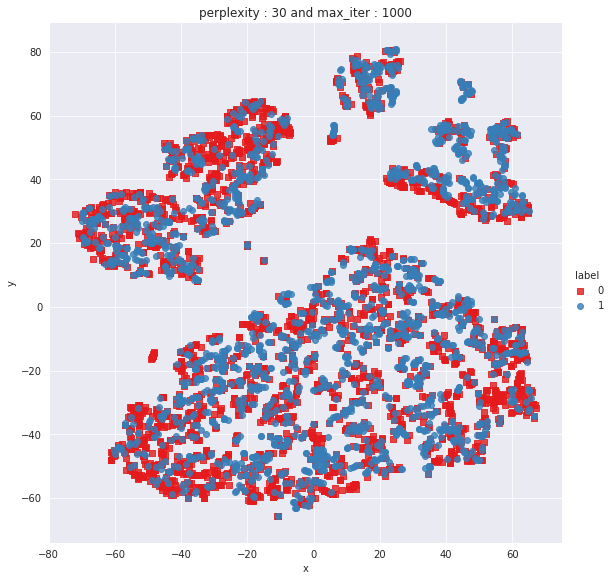

In [29]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, height=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

# 6. Make Data Model Ready:

In [30]:
y_train = train["target"].values
train = train.drop(['target'], axis=1)

### 6.1 Encoding text feature 

#### TFIDF-W2V

In [31]:
import pickle
from tqdm import tqdm

In [32]:
with open('../input/glove-vectors/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [33]:
# TFIDF Word2Vec
# compute TFIDF word2vec for each review.
def train_tfidfw2v(x):
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(x)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
    tfidf_words = set(tfidf_model.get_feature_names())
    tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(x): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v_vectors.append(vector)
    return tfidf_w2v_vectors

In [34]:
tfidf_w2v_vectors_keyword = train_tfidfw2v(train['keyword'])
tfidf_w2v_vectors_text = train_tfidfw2v(train['text'])

tfidf_w2v_vectors_keyword_test = train_tfidfw2v(test['keyword'])
tfidf_w2v_vectors_text_test = train_tfidfw2v(test['text'])

100%|██████████| 3263/3263 [00:00<00:00, 7103.48it/s]


### 6.2 encoding numerical features:

In [35]:
x_train_fre_len_n_common_total_share_special = StandardScaler().fit_transform(train[['freq_keyword', 'textlen', 'keywordlen', 'text_n_words', 'keyword_n_words', 'word_Common', 'word_Total', 'word_share', 'n_special_word']])
x_test_fre_len_n_common_total_share_special = StandardScaler().fit_transform(test[['freq_keyword', 'textlen', 'keywordlen', 'text_n_words', 'keyword_n_words', 'word_Common', 'word_Total', 'word_share', 'n_special_word']])
print("after Standardizing numerical features")
print(x_train_fre_len_n_common_total_share_special.shape, y_train.shape)
print(x_test_fre_len_n_common_total_share_special.shape)

after Standardizing numerical features
(7613, 9) (7613,)
(3263, 9)


#### Concatinating all the features: (standardscalar + tfidfW2v)

In [36]:
X_train_tfidf_w2v = sparse.csr_matrix(np.hstack((tfidf_w2v_vectors_keyword, 
                                                   tfidf_w2v_vectors_text,
                                                   x_train_fre_len_n_common_total_share_special)))

X_test_tfidf_w2v = sparse.csr_matrix(np.hstack((tfidf_w2v_vectors_keyword_test, 
                                                  tfidf_w2v_vectors_text_test,
                                                  x_test_fre_len_n_common_total_share_special)))


print("Final Data matrix for tfidf set 2")
print(X_train_tfidf_w2v.shape, y_train.shape)
print(X_test_tfidf_w2v.shape)

Final Data matrix for tfidf set 2
(7613, 609) (7613,)
(3263, 609)


# 7. Machine Learning Model

<h2> 7.1 XGB with hyperparameter tuning </h2>

In [37]:
def plot_roc_curve(fpr_tr, tpr_tr):
    '''
    plot the ROC curve for the FPR and TPR value
    '''
    plt.plot(fpr_tr, tpr_tr, 'k.-', color='green', label='ROC_train AUC = {:0.2f} '.format(auc(fpr_tr, tpr_tr)))
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [38]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

[0]	train-logloss:0.687622
Will train until train-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.640926
[20]	train-logloss:0.605183
[30]	train-logloss:0.57602
[40]	train-logloss:0.552184
[50]	train-logloss:0.53177
[60]	train-logloss:0.514571
[70]	train-logloss:0.499343
[80]	train-logloss:0.485733
[90]	train-logloss:0.474023
[100]	train-logloss:0.463327
[110]	train-logloss:0.453509
[120]	train-logloss:0.444304
[130]	train-logloss:0.436417
[140]	train-logloss:0.428818
[150]	train-logloss:0.421727
[160]	train-logloss:0.414983
[170]	train-logloss:0.408628
[180]	train-logloss:0.402399
[190]	train-logloss:0.396476
[200]	train-logloss:0.390547
[210]	train-logloss:0.38501
[220]	train-logloss:0.379742
[230]	train-logloss:0.374591
[240]	train-logloss:0.369728
[250]	train-logloss:0.365222
[260]	train-logloss:0.360793
[270]	train-logloss:0.356628
[280]	train-logloss:0.35261
[290]	train-logloss:0.348591
[300]	train-logloss:0.344773
[310]	train-logloss:0.340957
[320]	train-logloss:0.3373

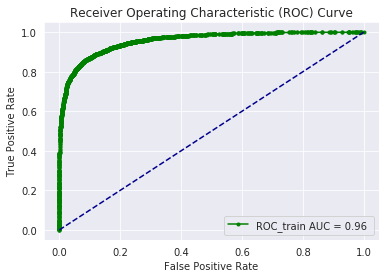

In [39]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train_tfidf_w2v, label=y_train)

watchlist = [(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

predict_y = bst.predict(d_train)
print("The test log loss is:",log_loss(y_train, predict_y, eps=1e-15))

fpr_tfidf, tpr_tfidf, t_tfidf = roc_curve(y_train, predict_y)
print('F1 score',f1_score(y_train,predict_with_best_t(predict_y, find_best_threshold(t_tfidf,fpr_tfidf,tpr_tfidf))))
plot_roc_curve(fpr_tfidf,tpr_tfidf)

In [40]:
submission = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
d_test = xgb.DMatrix(X_test_tfidf_w2v)
y_ = bst.predict(d_test)
y_pred = predict_with_best_t(y_, find_best_threshold(t_tfidf,fpr_tfidf,tpr_tfidf))

the maximum value of tpr*(1-fpr) 0.7851847981951577 for threshold 0.438


In [41]:
submission['target'] = y_pred
submission.to_csv('submission.csv', index=False)

# This is my first prediction Competition @ Kaggle :) Hope it is helpful. Please upvote if you like this kernel.